In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models

from torchvision.utils import make_grid # よくわからない

torch.set_printoptions(edgeitems=2)
torch.manual_seed(456)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
data_path = './data'

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
len(cifar10_val)

10000

In [5]:
train_loader = DataLoader(cifar10, 400, shuffle=True, num_workers=5, pin_memory=True)
val_loader = DataLoader(cifar10_val, 800, num_workers=5, pin_memory=True)

In [6]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


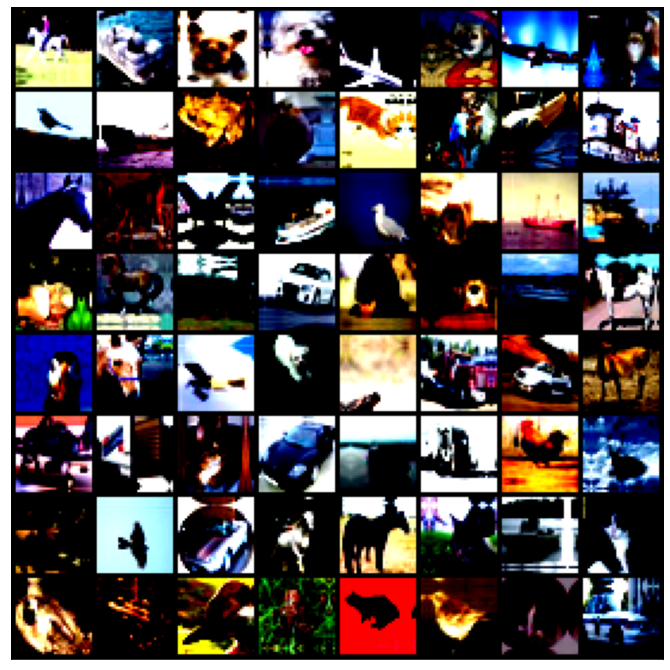

In [7]:
show_batch(train_loader)

In [8]:
device = (torch.device("cuda") if torch.cuda.is_available()
          else torch.device("cpu"))
print(f"Training on device {device}")

Training on device cuda


In [9]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [11]:
class Res(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128))
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.cf = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, 10))
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.cf(out)
        return out

In [12]:
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def validation_step(model, loss_fn, batch):
    imgs, labels = batch
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    outs = model(imgs)
    loss = loss_fn(outs, labels)
    acc = accuracy(outs, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

@torch.no_grad()
def evaluate(model, val_loader, loss_fn):
    model.eval()
    outputs = []
    for batch in val_loader:
        output = validation_step(model, loss_fn, batch)
        outputs.append(output)
    batch_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [13]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        model.train()
        loss_train = 0.0
        
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            lrs = []
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            # optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train += loss.item()
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, val_loader, loss_fn)
        val_loss = result["val_loss"]
        val_acc = result["val_acc"]
        lr = lrs[-1]
        print(f"{datetime.datetime.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader):.3f}, val_loss {val_loss:.3f}, val_acc {val_acc:.3f}, lr {lr}")

In [15]:
""" model = models.resnet34(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=10)
model.to(device=device)
model """

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
epochs = 40
max_lr = 0.01
model = Res().to(device=device)
optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))


training_loop(n_epochs=epochs, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader, val_loader=val_loader)

2022-05-24 02:03:15.701147 Epoch 1, Training loss 1.333, val_loss 0.957, val_acc 0.658, lr 0.0005611778951200488
2022-05-24 02:03:47.295371 Epoch 2, Training loss 0.853, val_loss 0.809, val_acc 0.727, lr 0.0010388928191738863
2022-05-24 02:04:19.319506 Epoch 3, Training loss 0.685, val_loss 0.792, val_acc 0.724, lr 0.0018005566292045132
2022-05-24 02:04:51.286459 Epoch 4, Training loss 0.584, val_loss 0.912, val_acc 0.696, lr 0.0027941943144879616
2022-05-24 02:05:23.405873 Epoch 5, Training loss 0.551, val_loss 0.924, val_acc 0.699, lr 0.003952001249586827
2022-05-24 02:05:56.251604 Epoch 6, Training loss 0.535, val_loss 0.767, val_acc 0.760, lr 0.005194970099407123
2022-05-24 02:06:28.240085 Epoch 7, Training loss 0.519, val_loss 0.669, val_acc 0.783, lr 0.0064382821835176855
2022-05-24 02:07:00.454169 Epoch 8, Training loss 0.482, val_loss 0.682, val_acc 0.778, lr 0.0075970953995974175
2022-05-24 02:07:32.916979 Epoch 9, Training loss 0.469, val_loss 0.642, val_acc 0.798, lr 0.00859

In [ ]:
model_path = "model.pth"
torch.save(model.state_dict(), model_path)